In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## The extraction stage

Extraction stage is happening in "api_data_extraction.py".

In this stage I extracted soccer data from api-sports.io. I was mainly intersted in teams, results and dates of games. I decided to collect data from 36 biggest soccer leagues and across all of the available seasons (for different leagues there are different number of seasons available).

To call the API I used requests Python library. The API provides data in json format so I parsed it using json Python library and collected data in a pandas DataFrame.

The API stores odds only for 1 week so when calling API for the last season I also collected odds data. I deliberately saved the games and the odds datasets in different files to exclude the possibility of evaluating the model on the training data.

Free version of the API provides only 10 requests per minute and 100 per day. That is why I added a function to count API calls and react when limits are exceeded.

Below you can see the shape and the head of the games and the odds datasets.

In [2]:
games_df = pd.read_pickle("data/games.pkl")
print(f"{games_df.shape = }")
games_df.head()

games_df.shape = (74940, 8)


,game_id,home_team_id,away_team_id,result,goal_difference,date,league_id,season
0,65,33,46,1,1,2018-08-10,39,2018
1,66,34,47,-1,-1,2018-08-11,39,2018
2,67,35,43,1,2,2018-08-11,39,2018
3,68,36,52,-1,-2,2018-08-11,39,2018
4,69,37,49,-1,-3,2018-08-11,39,2018


In [3]:
odds_df = pd.read_pickle("data/evaluation.pkl")
print(f"{odds_df.shape = }")
odds_df.head()

odds_df.shape = (2395, 11)


,game_id,home_team_id,away_team_id,result,goal_difference,date,league_id,season,home_odd,draw_odd,away_odd
0,4860,334,327,1,1,2018-05-21,103,2018,2.25,3.5,2.7
1,4880,327,324,0,0,2018-05-06,103,2018,2.20,3.3,2.9
2,4891,334,328,-1,-1,2018-04-29,103,2018,2.20,3.2,3.0
3,4897,326,329,0,0,2018-04-22,103,2018,1.95,3.4,3.4
4,4898,328,324,1,1,2018-04-22,103,2018,2.25,3.2,2.9


## The loading stage

The loading stage is happening in "load_games_to_db.py".

In this stage I connected to AWS RDS database using pymysql Python library, created tables and loaded the games and the odds datasets using MySQL.

Below you can see the tables schemas.

CREATE TABLE IF NOT EXISTS games (<br>
    &emsp;&emsp;game_id INT NOT NULL PRIMARY KEY,<br>
    &emsp;&emsp;home_team_id INT NOT NULL,<br>
    &emsp;&emsp;away_team_id INT NOT NULL,<br>
    &emsp;&emsp;result INT NOT NULL,<br>
    &emsp;&emsp;goal_difference INT NOT NULL,<br>
    &emsp;&emsp;date DATE NOT NULL,<br>
    &emsp;&emsp;league_id INT NOT NULL,<br>
    &emsp;&emsp;season INT NOT NULL<br>
    )

CREATE TABLE IF NOT EXISTS evaluation (<br>
    &emsp;&emsp;game_id INT NOT NULL PRIMARY KEY,<br>
    &emsp;&emsp;home_team_id INT NOT NULL,<br>
    &emsp;&emsp;away_team_id INT NOT NULL,<br>
    &emsp;&emsp;result INT NOT NULL,<br>
    &emsp;&emsp;goal_difference INT NOT NULL,<br>
    &emsp;&emsp;date DATE NOT NULL,<br>
    &emsp;&emsp;league_id INT NOT NULL,<br>
    &emsp;&emsp;season INT NOT NULL,<br>
    &emsp;&emsp;home_odd FLOAT NOT NULL,<br>
    &emsp;&emsp;draw_odd FLOAT NOT NULL,<br>
    &emsp;&emsp;away_odd FLOAT NOT NULL<br>
    )

## The transforming stage

The transforming stage is happening in "transform_data.py".

In this stage I transformed previously collected data to format suitable for training the neural network. For each game (where it was possible) I transformed 15 last games of each team and 4 last head-to-heads into one array. Aslo I transformed result into one-hot category encoding ([home_win, draw, away_win]).

Below you can see the shape and the head of the neural_net dataset.

In [4]:
neural_net_df = pd.read_pickle("data/neural_net.pkl")
print(f"{neural_net_df.shape = }")
neural_net_df.head()

neural_net_df.shape = (27417, 3)


,game_id,data,label
0,65,"[0, 0, 3, 2, 2, 0, 4, 1, 4, -1, 1, -1, 3, 1, 2...","[1, 0, 0]"
1,72,"[-2, -3, 0, 3, 4, -5, 0, 1, 0, -3, 3, 3, 3, 0,...","[1, 0, 0]"
2,74,"[0, 1, -1, -2, -1, -4, 3, 0, 2, 2, -1, 3, 1, -...","[0, 0, 1]"
3,80,"[2, -1, 1, 0, -3, 2, 0, -1, 1, -3, 0, -3, -2, ...","[0, 0, 1]"
4,81,"[1, 2, -3, 0, 2, 1, 0, 4, -1, 2, 1, 1, 4, 0, 1...","[1, 0, 0]"


## The modeling stage

The modeling stage is happening in "neural_net.py".

In this stage I converted previously transformed data into NumPy ndarray. Then I splitted the data into training and testing subsets using sklearn.model_selection.train_test_split.

Then I built the neural network using Keras. I decided to make all of the layers dense. I chose Adam optimizer as it is optimal for most of the tasks. For our task categorical_crossentropy loss function is the best option because it is used for multi-class classification models where there are two or more output labels (which is exactly our case).

The shape of the input layer is 15 (number of last games) * 2 (for each team) + 4 (number of head-to-heads) = 34.

The data I am using is not very complex so I decided to use only one hidden layer with 256 neurons. After a bit of exploration I chose sigmoid activation function for the hidden layer as it performed the best (the reason is that sigmoid squeezes all values betweem 0 and 1 which is what we are looking for).

The shape of the output layer is 3 (one-hot category encoding ([home_win, draw, away_win])). I am using softmax activation function in the output layer to convert a vector of output values into a vector of probabilities.

With such parameters neural network is achieving a little above 50% accuracy on average.

## The evaluation stage

The evaluation stage is happening in "evaluation.py".

You might think that with the accuracy a little above 50% the model would not be able to earn money but the catch is that we have probability distribution as the output and we are not obliged to bet on every game.

In this stage I evaluate system with different parameters of betting (<br>
    min_bet_limit: min amount of money we can bet on a game, <br>
    max_bet_limit: max amount of money we can bet on a game, <br>
    min_prediction_confidence: min probability of the result that we are going to bet on<br>
    )
    
Each time I give system 1000 points that represent money. I store results of every evaluation and all bets of the best one. You can see them below.

I noticed that after probability reaches 70% a lot of the gueses are correct. That is why I built a function the increses the bet based on the confidence with doubled speed after 70%. The function is the reason why systems with 0.5 as their min_prediction_confidence, low min_bet_limit and high max_bet_limit perform the best. They bet very little money on risky games and a lot of money on safe games.

In [5]:
eval_results_df = pd.read_pickle("data/eval_results.pkl")
eval_results_df.sort_values("gain", ascending=False).head()

,min_bet_limit,max_bet_limit,min_prediction_confidence,gain,biggest_win,biggest_loss,average_bet,average_gain,no_bets,bets_won,bets_lost
25,10.0,500.0,0.50,2184.901820,280.398781,-378.297945,117.0,6.172039,0.612,0.242,0.146
57,20.0,500.0,0.50,2141.026272,281.819214,-380.781660,124.0,6.048097,0.612,0.242,0.146
89,50.0,500.0,0.50,2009.399630,293.066043,-388.232806,148.0,5.676270,0.612,0.242,0.146
114,75.0,500.0,0.55,1957.523134,274.205106,-359.102328,170.0,8.510970,0.748,0.172,0.080
90,50.0,500.0,0.55,1948.259788,261.478348,-350.814229,151.0,8.470695,0.748,0.172,0.080


In [6]:
best_params = pd.read_pickle("data/best_params.pkl")
best_params.head(15)

,game_id,bet,odd,gain,money
0,11225.0,327.939461,1.19,62.308498,1062.308498
1,11621.0,59.536648,2.15,68.467145,1130.775643
2,11728.0,21.425261,3.05,-21.425261,1109.350381
3,11845.0,96.167217,2.80,-96.167217,1013.183164
4,11892.0,162.463828,5.50,-162.463828,850.719335
5,11896.0,15.520453,3.80,-15.520453,835.198882
6,11899.0,91.312083,1.30,27.393625,862.592507
7,11900.0,133.594534,1.65,86.836447,949.428954
8,11902.0,129.039932,1.25,32.259983,981.688937
9,11908.0,71.878461,3.90,-71.878461,909.810477


As you can see below system is mainly earning money from save bets with low odds (from 1 to 2). It loses the most money in medium odds (from 3 to 6). Aslo there are rare mistakes of betting on results with high odds.

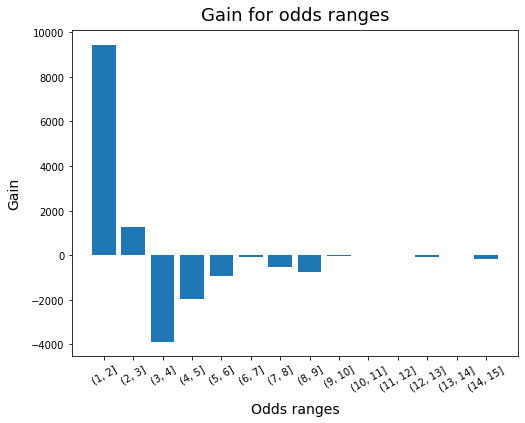

In [7]:
odds_and_gains = best_params.groupby(pd.cut(best_params["odd"], np.arange(1, 16, 1))).sum()["gain"]
odds_and_gains_df = odds_and_gains.to_frame()
odds_and_gains_df['label'] = odds_and_gains.keys().astype(str)

plt.bar(x=odds_and_gains_df.label, height=odds_and_gains_df.gain)
plt.title("Gain for odds ranges", fontsize=18, pad=10)
plt.xlabel("Odds ranges", fontsize=14, labelpad=10)
plt.ylabel("Gain", fontsize=14, labelpad=10)
plt.xticks(rotation = 30)
fig = plt.gcf()
fig.set_size_inches(8, 6)
plt.show()

### Extra evaluation games

Unfortunately, since the API only stores odds for one week and I started evaluation in the summer when all the seasons were over I was left with too little games for evaluation. That's why I found this dataset on Kaggle (https://www.kaggle.com/datasets/eladsil/football-games-odds). Author claims he has been collecting data from a real bookmaker for 2 years.

So my task was to match these games with the ones from the API. That is what I did in "extra_evaluation_games.py". I matched games based on teams and dates.

## Conclusion

Football prediction system is a good system that is able to earn money in a long-term perspective. Though it is fair to say that the system has flows and potential for improvement.